In [1]:
%pip install opencv-python matplotlib imageio gdown tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
%pip install gdown

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import gdown

In [5]:
%pip uninstall gdown -y

Found existing installation: gdown 5.2.0
Uninstalling gdown-5.2.0:
  Successfully uninstalled gdown-5.2.0
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install gdown

Defaulting to user installation because normal site-packages is not writeable
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
import gdown

In [8]:
# Download the zip file containing the data from Google Drive using its ID
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
# Use gdown library to download the file from the URL and save it to output file
gdown.download(url,output,quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=21c76d87-ac97-4e9d-97a7-ee4893cf4390
To: c:\Users\9112\Downloads\data.zip
100%|██████████| 423M/423M [00:39<00:00, 10.6MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [9]:
def load_video(path:str) -> List[float]:

    # Open the video file
    cap = cv2.VideoCapture(path)

    # Initialize an empty list to store preprocessed frames
    frames = []

    # Iterate through each frame in the video
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()

        # Convert the frame to grayscale
        frame = tf.image.rgb_to_grayscale(frame)

        # Crop the frame to focus only on the lips and append the preprocessed frame to the list
        frames.append(frame[190:236,80:220,:])
    cap.release()

    # Calculate the mean and standard deviation of the frames
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    # Normalize the frames by subtracting the mean and dividing by the standard deviation
    return tf.cast((frames - mean), tf.float32) / std

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
#Create a StringLookup layer to map characters to integers
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
#Create a StringLookup layer to map integers back to characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

#Print the vocabulary size and content of the StringLookup layer
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [12]:
char_to_num(['s','k','a','t','y'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([19, 11,  1, 20, 25], dtype=int64)>

In [13]:
num_to_char([19, 11,  1, 20, 25])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b's', b'k', b'a', b't', b'y'], dtype=object)>

In [14]:
# Define a function to load alignments from a given path
def load_alignments(path:str) -> List[str]:
    # Open the file in read mode and get all the lines
    with open(path, 'r') as f:
        lines = f.readlines()

    # Initialize an empty list to hold the tokens
    tokens = []

    # Loop through each line in the file
    for line in lines:
        line = line.split() # Split the line into a list of words
        if line[2] != 'sil': # If the third word in the line is not 'sil'
            tokens = [*tokens,' ',line[2]] # Append a space and the third word to the tokens list

    # Split the tokens into individual characters, convert them to numerical values using char_to_num, and return the result
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [15]:

def load_data(path: tf.Tensor): 
    # Decode tensor to string
    path_str = path.numpy().decode('utf-8')
    # Get the file name from the path and remove the file extension
    file_name = os.path.basename(path_str).split('.')[0]
    
    # Build paths to video and alignment files using the specified absolute path
    video_path = os.path.join('C:\\', 'Users', '9112', 'Downloads', 'data1', 'data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('C:\\', 'Users', '9112', 'Downloads', 'data1', 'data', 'alignments', 's1', f'{file_name}.align')
    
    # Load video frames and text alignments
    frames = load_video(video_path) 
    
    # Check if alignment file exists before loading
    if not os.path.exists(alignment_path):
        raise FileNotFoundError(f"Alignment file not found: {alignment_path}")
    
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [16]:
test_path = 'C:\\Users\\9112\\Downloads\\data1\\data\\s1\\bbal6n.mpg'

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'C:\\Users\\9112\\Downloads\\data1\\data\\s1\\bbal6n'

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [19]:
# tf.config.set_visible_devices([], 'GPU')  # Disable GPU

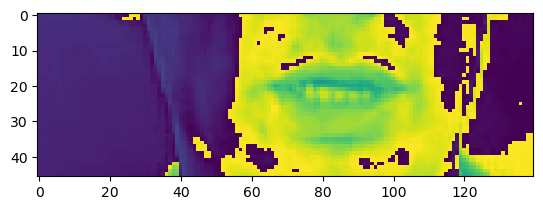

In [20]:
plt.imshow(frames[28])

In [21]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [22]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]).numpy().decode('utf-8')

'bin blue at l six now'

In [23]:
def mappable_function(path:str) ->List[str]:
    # Call the load_data function using TensorFlow's py_function, which can be used to wrap Python functions
    # and make them usable inside a TensorFlow graph.
    # This allows us to load and preprocess data in parallel with TensorFlow's data pipeline.
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    # Return the loaded and preprocessed data
    return result

In [24]:
# Get list of file paths for all videos
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
# Shuffle the order of the videos
data = data.shuffle(500, reshuffle_each_iteration=False)
# Map the load_data function to each file path and get frames and alignments
data = data.map(mappable_function)
# Padded batch of 2 videos, with frames padded to 75 frames and alignments padded to 40 characters
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
# Prefetch to optimize for performance
data = data.prefetch(tf.data.AUTOTUNE)
# Split the data into train and test sets
train = data.take(450)
test = data.skip(450)

In [25]:
len(test)

50

In [26]:
import os

# Example for setting the file name correctly
file_name = "bbal6n"  # Make sure this matches the actual file

# Constructing the path
alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

# Debugging outputs
print("File Name:", file_name)  # Check if file_name is correct
print("Alignment Path:", alignment_path)  # Check constructed path

# Check if the file exists
if not os.path.exists(alignment_path):
    raise FileNotFoundError(f"The alignment file does not exist: {alignment_path}")

# Proceed to use the dataset
frames, alignments = data.as_numpy_iterator().next()

File Name: bbal6n
Alignment Path: data\alignments\s1\bbal6n.align


In [27]:
frames, alignments = data.as_numpy_iterator().next()

In [28]:
len(frames)

2

In [29]:
sample = data.as_numpy_iterator()

In [30]:
val = sample.next(); val[0]

array([[[[[ 1.5370506 ],
          [ 1.3906648 ],
          [ 1.3540684 ],
          ...,
          [ 0.40256086],
          [ 0.40256086],
          [ 0.40256086]],

         [[ 1.6102434 ],
          [ 1.4638578 ],
          [ 1.2076826 ],
          ...,
          [ 0.40256086],
          [ 0.40256086],
          [ 0.40256086]],

         [[ 1.573647  ],
          [ 1.573647  ],
          [ 1.4638578 ],
          ...,
          [ 0.4391573 ],
          [ 0.36596444],
          [ 0.36596444]],

         ...,

         [[ 1.1344898 ],
          [ 1.1344898 ],
          [ 1.1344898 ],
          ...,
          [ 0.14638577],
          [ 0.14638577],
          [ 0.14638577]],

         [[ 1.0978932 ],
          [ 1.0978932 ],
          [ 1.0978932 ],
          ...,
          [ 0.10978933],
          [ 0.07319289],
          [ 0.07319289]],

         [[ 1.0978932 ],
          [ 1.0978932 ],
          [ 1.0978932 ],
          ...,
          [ 9.332093  ],
          [ 9.332093  ],
          

In [31]:
import numpy as np
import imageio

# Assuming val[0][0] contains your video frames
frames = val[0][0]

# Ensure frames are in uint8 format (values between 0 and 255)
frames_uint8 = (frames * 255).astype(np.uint8)

# Reshape frames if necessary
# If your frames are single-channel (like grayscale), reshape them to (height, width)
if frames_uint8.shape[-1] == 1:  # Single-channel image
    frames_uint8 = np.squeeze(frames_uint8, axis=-1)  # Remove the last dimension

# Now save the frames as a GIF
imageio.mimsave('./animation.gif', frames_uint8, fps=10)

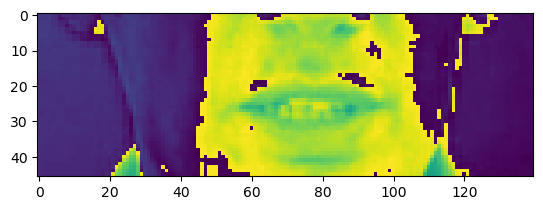

In [32]:
plt.imshow(val[0][0][35])

In [33]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green with b four now'>

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [35]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [36]:
model = Sequential()
#Add a Conv3D layer with 128 filters, kernel size of 3, and padding of 'same', with input shape of (75,46,140,1)
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
#Add a MaxPool3D layer with pool size of (1,2,2)
model.add(MaxPool3D((1,2,2)))

#Add another Conv3D layer with 256 filters, kernel size of 3, and padding of 'same'
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

#Add another Conv3D layer with 75 filters, kernel size of 3, and padding of 'same'
model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

#Add a TimeDistributed layer with Flatten
model.add(TimeDistributed(Flatten()))

#Add a Bidirectional LSTM layer with 128 units, orthogonal kernel initializer, and return_sequences=True
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

#Use a He normal initializer and softmax activation
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


In [39]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b"eeeeee''''''''''''zzzzzzz''''zzzzzz'''''''''''''''''''''eeeeeee''''gggggggg">

In [40]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b"eeeeee''''''''''''zzzzzzz''''zzzzzz'''''''''''''''''''''eeeeeee''''gggggggg">

In [41]:
def scheduler(epoch, lr):
    #If the epoch is less than 30, the current learning rate is returned without any modification.
    if epoch < 30:
        return lr
    else:
        #After the 30th epoch, the learning rate is multiplied by e^(-0.1) for every subsequent epoch.
        return lr * tf.math.exp(-0.1)

In [42]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    # Create tensors of shape (batch_size, 1) with the input and label lengths
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # Compute the CTC loss using the backend function ctc_batch_cost
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [43]:
class ProduceExample(tf.keras.callbacks.Callback):
    # Constructor of the callback class, which takes in a dataset as input and initializes it
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    # Callback function which is called at the end of each epoch
    def on_epoch_end(self, epoch, logs=None) -> None:
        # Get the next batch of data from the dataset iterator
        data = self.dataset.next()
        # Predict the output for the current batch using the model
        yhat = self.model.predict(data[0])
        # Decode the predicted output using CTC decoding
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        # Iterate over each item in the batch
        for x in range(len(yhat)):
            # Print the original label of the item
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            # Print the predicted label of the item
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            # Print a line of dashes for better visualization
            print('~'*100)

In [44]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [45]:
checkpoint_callback = ModelCheckpoint(
    os.path.join('models', 'checkpoint.weights.h5'),  # Ensure it ends with .weights.h5
    monitor='loss',
    save_weights_only=True
)

In [46]:
schedule_callback = LearningRateScheduler(scheduler)

In [47]:
example_callback = ProduceExample(test)

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, Flatten
from tensorflow.keras.models import Model

# Assuming (batch_size, time_steps, height, width, channels) = (None, 75, 46, 140, 1)
time_steps = 75
height = 46
width = 140
channels = 1

# Define the model input shape
inputs = Input(shape=(time_steps, height, width, channels))

# Example model architecture
x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(inputs)
x = TimeDistributed(Flatten())(x)

# Create the model
model = Model(inputs, x)

# Print model summary to check architecture
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 75, 46, 140, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 75, 44, 138,    │           320 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 75, 194304)     │             0 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.fit(data, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node functional_16_1/time_distributed_6_1/Reshape_11 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\ProgramData\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "c:\ProgramData\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\ProgramData\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\ProgramData\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\ProgramData\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\9112\AppData\Local\Temp\ipykernel_54044\3135355164.py", line 1, in <module>

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 51, in train_step

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 901, in __call__

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 175, in call

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 560, in call

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 901, in __call__

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in call

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in <listcomp>

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 102, in step_function

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\ops\numpy.py", line 4440, in reshape

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1789, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node functional_16_1/time_distributed_6_1/Reshape_11}}]] [Op:__inference_one_step_on_iterator_35869]

In [205]:
# URL to the zip file containing checkpoints
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# Name of the output zip file
output = 'checkpoints.zip'
# Download the zip file from Google Drive
gdown.download(url, output, quiet=False)
# Extract the contents of the zip file to the 'models' folder
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=f3daade9-06a8-4675-bd4c-82405f4fb5bd
To: c:\Users\9112\Downloads\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:17<00:00, 5.43MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [221]:
%pip install keras==2.11.0 tensorflow==2.11.0

import os
import keras
import tensorflow as tf

os.environ['TF_USE_LEGACY_KERAS'] = '1'

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tensorflow==2.11.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.18.0rc0, 2.18.0rc1)
ERROR: No matching distribution found for tensorflow==2.11.0


In [222]:
print("Keras Version:", keras.__version__)
print("TensorFlow Version:", tf.__version__)

Keras Version: 3.5.0
TensorFlow Version: 2.17.0


In [223]:
checkpoint_directory = 'models/'
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_directory)).expect_partial()

In [224]:
model.save_weights('models/checkpoint.weights.h5')

In [225]:
from tensorflow.keras.optimizers import Adam  # Using Adam optimizer

optimizer = Adam(lr=0.001)

model.compile(loss=CTCLoss, optimizer=optimizer)

model.load_weights('models/checkpoint.weights.h5')

ValueError: Argument(s) not recognized: {'lr': 0.001}

In [226]:
test_data = test.as_numpy_iterator()

In [ ]:
test_data = test.as_numpy_iterator()

# Instead of fetching the entire next sample in one go, use batching or smaller samples
try:
    # Fetch just one small batch (adjust based on your dataset)
    sample = test_data.next()  # Get the next item, but watch for memory issues
    print('Sample fetched successfully')

    # You can also print out the shape of the sample to inspect its size
    print(f"Sample shape: {sample[0].shape}")

except StopIteration:
    print("No more data in the test dataset")

In [ ]:
## test start

In [ ]:
# Get predictions
yhat = model.predict(sample[0])

In [ ]:
# Print the actual text
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
# Decode using beam search for better accuracy
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75, 75], greedy=False, beam_width=10)[0][0].numpy()

In [ ]:
# Print the decoded predictions
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
## test end

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
yhat.shape

In [ ]:
## test

In [ ]:
# sample = load_data(tf.convert_to_tensor('./data/s1/bbaf3s.mpg'))

In [ ]:
# print('~'*100, 'REAL TEXT')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
# decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
# print('~'*100, 'PREDICTIONS')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]